# CELLxGENE Discover Census Workshop - CSHL Single-Cell Analysis 2023

This notebook is a step-by-step walkthrough of the CELLxGENE Discover Census Workshop at CSHL's Single-Cell Analysis, 2023.

## License

MIT License

Copyright (c) 2022-2023 Chan Zuckerberg Initiative Foundation.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Workshop

### Installation

To install the Census API on your laptop, follow the [installation instructions](https://chanzuckerberg.github.io/cellxgene-census/cellxgene_census_docsite_installation.html) in the documentation site.

To install in this Colab environment you need to execute the following.

In [1]:
!pip install cellxgene_census > /dev/null

In [2]:
!pip install scikit-misc > /dev/null

In [3]:
!pip install scanpy > /dev/null

**🚨 NOTE:** If you are running this notebook from Google Colab restart your Runtime before continuing.

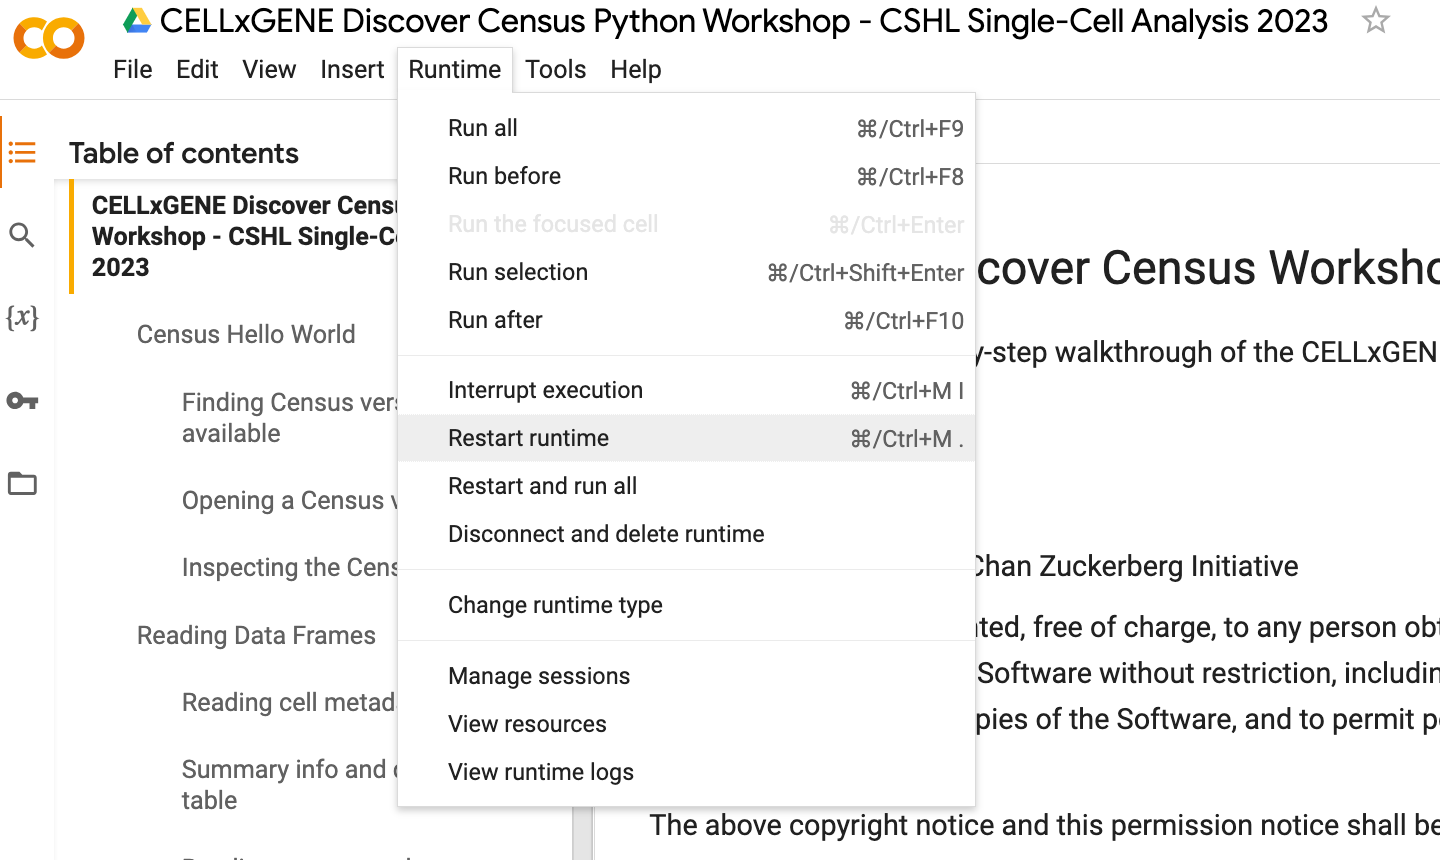

### Census Hello World

Let's load the necessary libraries

In [4]:
import cellxgene_census
import tiledbsoma
import scipy
import numpy
import scanpy as sc
import pandas

Matplotlib is building the font cache; this may take a moment.


Let's also set some configuration settings for SOMA. This allows us to set the size of data we stream at any given time, as this will be relevant when we cover SOMA iterators.

In [5]:
# Default: 1GB
# Google colab runs well with 1MB
# TileDB-Cloud can run default, but recommended for workshop is 10MB
config = {
    "vfs.s3.region": "us-west-2",
    "vfs.s3.no_sign_request": "true",
    "py.init_buffer_bytes": 0.001 * 1024**3, #1MB
    "soma.init_buffer_bytes": 0.001 * 1024**3, #1MB
}

ctx = tiledbsoma.options.SOMATileDBContext()
ctx = ctx.replace(tiledb_config=config)

#### Finding Census versions available

Let's first take a look at the data releases available in S3. There are two types of releases:
- **Long-term supported (LTS) data releases** published every six months to be avalialbe for up to 5 years.
- **Weekly releases** to be available for up to 6 weeks.

To see a list of all available releases and their version aliases, we can do the following

In [6]:
cellxgene_census.get_census_version_directory()

OrderedDict([('stable',
              {'release_date': None,
               'release_build': '2024-07-01',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/',
                'relative_uri': '/cell-census/2024-07-01/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/',
                'relative_uri': '/cell-census/2024-07-01/h5ads/',
                's3_region': 'us-west-2'},
               'flags': {'lts': True}}),
             ('latest',
              {'release_date': None,
               'release_build': '2024-09-02',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/',
                'relative_uri': '/cell-census/2024-09-02/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/h5ads/',
        

In [7]:
cellxgene_census.get_census_version_directory(lts=True)

OrderedDict([('stable',
              {'release_date': None,
               'release_build': '2024-07-01',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/',
                'relative_uri': '/cell-census/2024-07-01/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/',
                'relative_uri': '/cell-census/2024-07-01/h5ads/',
                's3_region': 'us-west-2'},
               'flags': {'lts': True}}),
             ('2024-07-01',
              {'release_date': None,
               'release_build': '2024-07-01',
               'soma': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/',
                'relative_uri': '/cell-census/2024-07-01/soma/',
                's3_region': 'us-west-2'},
               'h5ads': {'uri': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/h5ads/',
    

#### Opening a Census version

Now we can get a handle to the Census object hosted in S3. Remember that we can specify the data release to use.

In [8]:
# For the latest LTS use "stable", other options are "latest" for the latest
# weekly, or specific version

version = "latest"

# equivalent
# version = "2023-07-25"

census = cellxgene_census.open_soma(census_version=version, context=ctx)

#### Inspecting the Census object

These are the types of SOMA objects used by Census:

- `SparseNDArray` is the same as DenseNDArray but sparse, and supports point indexing (disjoint index access).
- `DataFrame` is a multi-column table with user-defined columns names and value types, with support for point indexing.
- `Collection` is a persistent container of named SOMA objects, similar to a dictionary.
- `Experiment` is a class that represents a single-cell experiment. It always contains two objects:
   - `obs`: a `DataFrame` with primary annotations on the observation axis.
   - `ms`: a `Collection` of measurements, each composed of `X` matrices and axis annotation matrices or data frames (e.g. `var`, `varm`, `obsm`, etc).

The parent Census object is a SOMA `Collection`:

In [9]:
census

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/' (open for 'r') (2 items)
    'census_info': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info' (unopened)
    'census_data': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data' (unopened)>

You can access items of a collection with square brackets.

- `"census_data"` has the Census single-cell data, will explore it in a momemnt.
- `"census_info"` has high-level summary information about Census

Let's take a look at `"census_info"`

In [10]:
census["census_info"]

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info' (open for 'r') (4 items)
    'datasets': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/datasets' (unopened)
    'summary_cell_counts': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary_cell_counts' (unopened)
    'summary': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary' (unopened)
    'organisms': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/organisms' (unopened)>

There are three items in this collection:

- `"summary"`: A data frame with high-level information of this Census, e.g. build date, total cell count, etc.
- `"summary_cell_counts"`: A data frame with cell counts stratified by relevant cell metadata
- `"datasets"`: A data frame with all datasets from CELLxGENE Discover used to create the Census.

Now let's take a look at `"census_data"`.

In [11]:
census["census_data"]

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data' (open for 'r') (2 items)
    'homo_sapiens': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens' (unopened)
    'mus_musculus': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/mus_musculus' (unopened)>

These two are SOMA `Experiment` objects which are a specialized form of a `Collection`. Each of these store a data matrix (cells by genes), cell metadata, gene metadata, and some other useful components.

### Reading Data Frames


#### Reading cell metadata

Let's take a deeper dive into the single-cell data. As mentioned earlier, an `Experiment` always has an `obs` atrribute that can be accessed via `.obs`.

Let's take a look at the human `Experiment`.

In [12]:
census["census_data"]["homo_sapiens"]

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens/obs' (unopened)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens/ms' (unopened)>

In [13]:
census["census_data"]["homo_sapiens"].obs

<DataFrame 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_data/homo_sapiens/obs' (open for 'r')>

We can take a look at the columns available in a data frame with the `keys()` method, which shows the types of metadata available for each cell.

In [14]:
census["census_data"]["homo_sapiens"].obs.keys()

('soma_joinid',
 'dataset_id',
 'assay',
 'assay_ontology_term_id',
 'cell_type',
 'cell_type_ontology_term_id',
 'development_stage',
 'development_stage_ontology_term_id',
 'disease',
 'disease_ontology_term_id',
 'donor_id',
 'is_primary_data',
 'observation_joinid',
 'self_reported_ethnicity',
 'self_reported_ethnicity_ontology_term_id',
 'sex',
 'sex_ontology_term_id',
 'suspension_type',
 'tissue',
 'tissue_ontology_term_id',
 'tissue_type',
 'tissue_general',
 'tissue_general_ontology_term_id',
 'raw_sum',
 'nnz',
 'raw_mean_nnz',
 'raw_variance_nnz',
 'n_measured_vars')

Let's read two columns of the data frame.

In [15]:
census["census_data"]["homo_sapiens"].obs.read(column_names=["suspension_type", "tissue_general"]).concat().to_pandas()

,suspension_type,tissue_general
0,cell,liver
1,cell,liver
2,cell,liver
3,cell,liver
4,cell,liver
...,...,...
77665794,nucleus,brain
77665795,nucleus,brain
77665796,nucleus,brain
77665797,nucleus,brain


The line above retrieved the suspension type and tissue values for all human cells in Census. Let's dissect step-by-step to see what happened there:

1. `.read(column_names = ["suspension_type", "tissue_general"])` - creates an iterator of Arrow tables that can be used for chunked-based data streaming.
2. `.concat()` - retrieves all the results of the iterator and concatenates them into a single Arrow table.
3. `.to_pandas()` - converts the Arrow table into a Pandas data frame.

Let's do each step one more time and inspect the intermediate objects.

In [16]:
# Create iterator of Arrow tables
iterator = census["census_data"]["homo_sapiens"].obs.read(column_names=["suspension_type", "tissue_general"])
iterator

In [17]:
# We can get individual chunks
table_chunk = next(iterator)
table_chunk

pyarrow.Table
suspension_type: dictionary<values=string, indices=int8, ordered=0>
tissue_general: dictionary<values=string, indices=int8, ordered=0>
----
suspension_type: [  -- dictionary:
["cell","nucleus"]  -- indices:
[0,0,0,0,0,...,0,0,0,0,0]]
tissue_general: [  -- dictionary:
["adipose tissue","adrenal gland","axilla","bladder organ","blood",...,"tongue","ureter","uterus","vasculature","yolk sac"]  -- indices:
[27,27,27,27,27,...,39,39,39,39,39]]

In [18]:
table_chunk.to_pandas()

,suspension_type,tissue_general
0,cell,liver
1,cell,liver
2,cell,liver
3,cell,liver
4,cell,liver
...,...,...
1073736,cell,pleural fluid
1073737,cell,pleural fluid
1073738,cell,pleural fluid
1073739,cell,pleural fluid


In [19]:
# Or concatenate the remaining results into a single Arrow Table,
# and the convert to a Pandas DataFrame
table = iterator.concat()
pandas_obs = table.to_pandas()
pandas_obs

,suspension_type,tissue_general
0,cell,pleural fluid
1,cell,pleural fluid
2,cell,pleural fluid
3,cell,pleural fluid
4,cell,pleural fluid
...,...,...
76592053,nucleus,brain
76592054,nucleus,brain
76592055,nucleus,brain
76592056,nucleus,brain


In [20]:
# And you can perform pandas operations useful for your analysis
pandas_obs.value_counts()

suspension_type  tissue_general 
nucleus          brain              23787347
cell             blood              11092030
                 lung                6921814
                 breast              5390966
nucleus          eye                 3579187
                                      ...   
                 endocrine gland       10961
cell             gallbladder            9769
                 spinal cord            5916
nucleus          skin of body           5327
cell             ureter                 2390
Name: count, Length: 76, dtype: int64

#### Summary info and dataset table

The same reading operations can be applied to any SOMA data frame in Census. Let's take a look back at the items of `"census_info"`.

In [21]:
census["census_info"]

<Collection 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info' (open for 'r') (4 items)
    'datasets': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/datasets' (unopened)
    'summary_cell_counts': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary_cell_counts' (unopened)
    'summary': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary' (unopened)
    'organisms': 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/organisms' (unopened)>

`"summary"` is a data frame with high-level information of this data release.

In [22]:
census["census_info"]["summary"]

<DataFrame 's3://cellxgene-census-public-us-west-2/cell-census/2024-09-02/soma/census_info/summary' (open for 'r')>

In [23]:
census["census_info"]["summary"].read().concat().to_pandas()

,soma_joinid,label,value
0,0,census_schema_version,2.1.0
1,1,census_build_date,2024-09-02
2,2,dataset_schema_version,5.1.0
3,3,total_cell_count,120108090
4,4,unique_cell_count,64161082
5,5,number_donors_homo_sapiens,19993
6,6,number_donors_mus_musculus,4698


And `"datasets"` is data frame listing all of the datasets whose single-cell data is contained in this Census release.

**🚨 NOTE:** the column `dataset_id` is also present in the cell metadata for joining

In [24]:
census["census_info"]["datasets"].read().concat().to_pandas()

,soma_joinid,citation,collection_id,collection_name,collection_doi,collection_doi_label,dataset_id,dataset_version_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
0,0,Publication: https://doi.org/10.1002/hep4.1854...,44531dd9-1388-4416-a117-af0a99de2294,"Single-Cell, Single-Nucleus, and Spatial RNA S...",10.1002/hep4.1854,Andrews et al. (2022) Hepatology Communications,0895c838-e550-48a3-a777-dbcd35d30272,aaab3abd-624a-442e-b62b-3f2edb10b45e,Healthy human liver: B cells,0895c838-e550-48a3-a777-dbcd35d30272.h5ad,146
1,1,Publication: https://doi.org/10.1126/sciimmuno...,3a2af25b-2338-4266-aad3-aa8d07473f50,Single-cell analysis of human B cell maturatio...,10.1126/sciimmunol.abe6291,King et al. (2021) Sci. Immunol.,00ff600e-6e2e-4d76-846f-0eec4f0ae417,50c1d621-995d-4386-9fcb-5c70fcdf8d66,Human tonsil nonlymphoid cells scRNA,00ff600e-6e2e-4d76-846f-0eec4f0ae417.h5ad,363
2,2,Publication: https://doi.org/10.1038/s41593-02...,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vuln...,10.1038/s41593-020-00764-7,Leng et al. (2021) Nat Neurosci,bdacc907-7c26-419f-8808-969eab3ca2e8,e95b54b1-8656-4fe8-9f53-6fdd97f397ba,Molecular characterization of selectively vuln...,bdacc907-7c26-419f-8808-969eab3ca2e8.h5ad,3799
3,3,Publication: https://doi.org/10.1038/s41467-02...,bf325905-5e8e-42e3-933d-9a9053e9af80,Single-cell Atlas of common variable immunodef...,10.1038/s41467-022-29450-x,Rodríguez-Ubreva et al. (2022) Nat Commun,a5d95a42-0137-496f-8a60-101e17f263c8,d6e742c5-f6e5-42f4-8064-622783542f6b,Steady-state B cells - scRNA-seq,a5d95a42-0137-496f-8a60-101e17f263c8.h5ad,1324
4,4,Publication: https://doi.org/10.1038/s41590-02...,93eebe82-d8c3-41bc-a906-63b5b5f24a9d,Single-cell proteo-genomic reference maps of t...,10.1038/s41590-021-01059-0,Triana et al. (2021) Nat Immunol,d3566d6a-a455-4a15-980f-45eb29114cab,61f15353-e598-43b5-bb5a-80ac44a0cf0b,blood and bone marrow from a healthy young donor,d3566d6a-a455-4a15-980f-45eb29114cab.h5ad,15502
...,...,...,...,...,...,...,...,...,...,...,...
895,895,Publication: https://doi.org/10.1038/s41586-02...,45d5d2c3-bc28-4814-aed6-0bb6f0e11c82,A single-cell transcriptional timelapse of mou...,10.1038/s41586-024-07069-w,Qiu et al. (2024) Nature,0bce33ed-455c-4e12-93f8-b7b04a2de4a1,fa49086f-0e18-4f4b-908d-beefdb00ac3e,Whole dataset: Normalized subset 2,0bce33ed-455c-4e12-93f8-b7b04a2de4a1.h5ad,2863559
896,896,Publication: https://doi.org/10.1101/2023.05.0...,1ca90a2d-2943-483d-b678-b809bf464c30,SEA-AD: Seattle Alzheimer’s Disease Brain Cell...,10.1101/2023.05.08.539485,Gabitto et al. (2023) bioRxiv,c2876b1b-06d8-4d96-a56b-5304f815b99a,291ce735-8d18-4a2f-a6bc-98f75f8d6bc0,Whole Taxonomy - MTG: Seattle Alzheimer's Dise...,c2876b1b-06d8-4d96-a56b-5304f815b99a.h5ad,1226855
897,897,Publication: https://doi.org/10.1101/2023.05.0...,1ca90a2d-2943-483d-b678-b809bf464c30,SEA-AD: Seattle Alzheimer’s Disease Brain Cell...,10.1101/2023.05.08.539485,Gabitto et al. (2023) bioRxiv,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,e9bffe1d-9f07-4467-9230-c080b362e737,Whole Taxonomy - DLPFC: Seattle Alzheimer's Di...,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3.h5ad,1309414
898,898,Publication: https://doi.org/10.1038/s41586-02...,45d5d2c3-bc28-4814-aed6-0bb6f0e11c82,A single-cell transcriptional timelapse of mou...,10.1038/s41586-024-07069-w,Qiu et al. (2024) Nature,dcfa2614-7ca7-4d82-814c-350626eccb26,b8cfe635-1cf6-4a6d-8bc0-5059477b9a8c,Major cell cluster: Mesoderm,dcfa2614-7ca7-4d82-814c-350626eccb26.h5ad,3267338


#### Reading gene metadata

Reading gene metadata is similar to reading cell metadata. However the location of this data frame is inside the soma Measurement. This was designed to allow for multi-modal data, whereby the same observation (cell) can have a different set of features for each type of measurement (e.g. genes, proteins).

To read the gene metadata:

In [25]:
# Build iterator
iterator = census["census_data"]["homo_sapiens"].ms["RNA"].var.read()

# Grab first chunk
table_chunk=next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,ENSG00000000003,TSPAN6,4530,4811135,77128603
1,1,ENSG00000000005,TNMD,1476,269136,64017621
2,2,ENSG00000000419,DPM1,9276,18420588,77502438
3,3,ENSG00000000457,SCYL3,6883,9268173,76952827
4,4,ENSG00000000460,C1orf112,5970,6484239,76979490
...,...,...,...,...,...,...
60532,60532,ENSG00000288718,ENSG00000288718.1,1070,4,1248980
60533,60533,ENSG00000288719,ENSG00000288719.1,4252,2826,1248980
60534,60534,ENSG00000288724,ENSG00000288724.1,625,36,1248980
60535,60535,ENSG00000290735,ENSG00000290735.1,4103,128,49359


#### Reading a Data Frame with row filters

SOMA makes it easy and efficient to only select a subset of rows based on a query filter. This helps when you want to grab data or metadata only for specific set of cells or genes based on the columns available in these data frames.

For example if you want to get the all the the *primary cells* you can add the following.

**🚨 NOTE:** cells annotated as `is_primary_data = True` are those marked as the original contribution, as some cells are represented more than once in Census due to their inclusion in multiple datasets.

In [26]:
# Build iterator with a query filter
iterator = census["census_data"]["homo_sapiens"].obs.read(value_filter = "is_primary_data == True")

# Grab first chunk
table_chunk=next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,4308,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,17691.0,1199,14.754796,624.620960,19149
1,4309,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13612.0,841,16.185493,1394.944123,19149
2,4310,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,126774.0,1683,75.326203,42215.146798,19149
3,4311,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,14370.0,371,38.733154,4639.990763,19149
4,4312,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old human stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13738.0,507,27.096647,3874.079574,19149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107369,286422,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,2105.0,1357,1.551216,4.489447,20383
107370,286423,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,1791.0,1168,1.533390,2.197684,20383
107371,286424,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,4989.0,2761,1.806954,4.679024,20383
107372,286425,dc30c3ec-46d6-4cd8-8ec1-b544a3d0f503,10x 3' v2,EFO:0009899,neuron,CL:0000540,44-year-old human stage,HsapDv:0000138,multiple sclerosis,MONDO:0005301,...,brain,UBERON:0000955,tissue,brain,UBERON:0000955,5201.0,2811,1.850231,4.767241,20383


The `value_filter` works similalrly to a Pandas `query` interface. It can take a string of which is evaluated as a boolean condition and selects rows that meet the criteria.

We can then use other operators to build complex queries, for example all epithelial cells from lung that are primary representations.

In [27]:
filter = "is_primary_data == True and cell_type == 'epithelial cell' and tissue_general == 'lung'"
columns = ["assay"]

# Build iterator
iterator = census["census_data"]["homo_sapiens"].obs.read(
    value_filter = filter,
    column_names = columns,
)

# Grab first chunk
table_chunk=next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,assay,is_primary_data,cell_type,tissue_general
0,Smart-seq2,True,epithelial cell,lung
1,Smart-seq2,True,epithelial cell,lung
2,Smart-seq2,True,epithelial cell,lung
3,Smart-seq2,True,epithelial cell,lung
4,Smart-seq2,True,epithelial cell,lung
...,...,...,...,...
59361,10x 5' v2,True,epithelial cell,lung
59362,10x 5' v2,True,epithelial cell,lung
59363,10x 5' v2,True,epithelial cell,lung
59364,10x 5' v2,True,epithelial cell,lung


#### Reading a Data Frame with coordinates

Finally, you can also read a data frame via coordinates. This is useful when testing code with a small set of data.

In [28]:
 census["census_data"]["homo_sapiens"].obs.read(coords=([0,1,2,3,4,5],)).concat().to_pandas()

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,0,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,plasma cell,CL:0000786,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,1742.0,221,7.882353,6661.549733,13696
1,1,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,278.0,143,1.944056,3.616567,13696
2,2,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,plasma cell,CL:0000786,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,3723.0,709,5.251058,2959.510327,13696
3,3,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,351.0,179,1.960894,8.487226,13696
4,4,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,605.0,275,2.200000,18.978102,13696
5,5,0895c838-e550-48a3-a777-dbcd35d30272,10x 3' v2,EFO:0009899,mature B cell,CL:0000785,human adult stage,HsapDv:0000087,normal,PATO:0000461,...,caudate lobe of liver,UBERON:0001117,tissue,liver,UBERON:0002107,338.0,164,2.060976,11.444112,13696


### Reading expression data

The single-cell expression data is stored as a SOMA `SparseNDArray`. This is a sparse representation of the data that enables efficient storage and access for data with a high number of missing values.

Currently Census has two expression layers:

- Raw counts.
- Normalized counts by library size.

For human, these are located in the \"RNA\" measurement at:

- `["census_data"]["homo_sapiens"].ms["RNA"].X["raw"]`
- `["census_data"]["homo_sapiens"].ms["RNA"].X["normalized"]`

Reading these data works similarly to reading data frames. The main difference is that there are different types of iterators available. In this workshop we'll focus on Arrow table iterators.


In [29]:
# Creater a reader
reader = census["census_data"]["homo_sapiens"].ms["RNA"].X["raw"].read()

# Build an iterator of Arrow tables
iterator = reader.tables()

# Grab first chunk
table_chunk=next(iterator)

# Convert to pandas
table_chunk.to_pandas()

,soma_dim_0,soma_dim_1,soma_data
0,0,176,1.0
1,0,229,1.0
2,0,249,1.0
3,0,409,1.0
4,0,451,1.0
...,...,...,...
134212,1146,91,1.0
134213,1146,99,1.0
134214,1146,104,1.0
134215,1146,106,1.0


This produces an expression matrix in COO sparse format:

- `soma_dim_0` - the ID for the cell.
- `soma_dim_1` - the ID for the gene.  
- `soma_data` - the expression value.

You can then transform this table to other useful representations.

In [30]:
# SciPy formats
scipy_coo = scipy.sparse.coo_matrix((table_chunk["soma_data"], (table_chunk["soma_dim_0"], table_chunk["soma_dim_1"])))
scipy_coo

<1147x2048 sparse matrix of type '<class 'numpy.float32'>'
	with 134217 stored elements in COOrdinate format>

In [31]:
# Numpy formats
scipy_coo.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

**🚨 NOTE:** Reading the expression matrix in isolation is usually not very useful without cell and gene metadata. We'll cover that in the next section

### Atomic reading of expression data AND metadata

SOMA provides a convenient interface to query single-cell data in a metadata-aware fashion using `ExperimentAxisQuery`.

We covered in a previous section the concept of an SOMA `Experiment`, as a class that represents a single-cell experiment. It always contains two objects:
   - `obs`: a `DataFrame` with primary annotations on the observation axis.
   - `ms`: a `Collection` of measurements, each composed of `X` matrices and axis annotation matrices or data frames (e.g. `var`, `varm`, `obsm`, etc).

**🚨 NOTE:** An `ExperimentAxisQuery` enables users to query and slice an `Experiment` single-cell data and metadata using coordinates or value filters on the axes, similar to how a SOMA `DataFrame` is queried.

#### Creating an `ExperimentAxisQuery`

To create an `ExperimentAxisQuery` you can call the method `.axis_query()` of a SOMA `Experiment`.

In [32]:
cell_filter = "tissue_general == 'tongue'"
gene_filter = "feature_name in ['PECAM1', 'DCN', 'KRT13']"

query = census["census_data"]["homo_sapiens"].axis_query(
    measurement_name = "RNA",
    obs_query = tiledbsoma.AxisQuery(value_filter = cell_filter),
    var_query = tiledbsoma.AxisQuery(value_filter = gene_filter),
)

In [33]:
query

#### Inspecting the query results

Once the `ExperimentAxisQuery` is created you have access to a variety of convenient methods to fetch data or useful information about your query.

In [34]:
# Number of (cells, genes) in query
query.n_obs, query.n_vars

(45060, 3)

In [35]:
# Grabbing cell metadata
iterator = query.obs(column_names = ["cell_type", "tissue_general"])
iterator.concat().to_pandas()

,cell_type,tissue_general
0,epithelial cell,tongue
1,epithelial cell,tongue
2,epithelial cell,tongue
3,epithelial cell,tongue
4,epithelial cell,tongue
...,...,...
45055,keratinocyte,tongue
45056,keratinocyte,tongue
45057,basal cell,tongue
45058,keratinocyte,tongue


In [36]:
# Grabbing gene metadata
iterator = query.var()
iterator.concat().to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,299,ENSG00000011465,DCN,12941,7905731,75319655
1,12852,ENSG00000171401,KRT13,2913,712612,62927690
2,28763,ENSG00000261371,PECAM1,7741,7739030,64633082


#### Exporting query results to `AnnData`

`ExperimentAxisQuery` has the capability to export the query to an `AnnData` object to use for downstream analysis (e.g. with [Scanpy](https://scanpy.readthedocs.io/)).

In [37]:
# Convert to AnnData
adata = query.to_anndata(X_name="normalized")
adata

AnnData object with n_obs × n_vars = 45060 × 3
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [39]:
# Example: make an expression dot plot
adata.var_names=adata.var["feature_name"]
adata.X = adata.X * 10000
sc.pp.log1p(adata)
# TODO: broken in Scanpy 1.10.2?
# sc.pl.dotplot(adata, adata.var["feature_name"], groupby='cell_type');

**🚨 NOTE:** The Census package provides a convinient way to get an AnnData object without creating an Experiment Query:

```python
adata = cellxgene_census.get_anndata(
  census = census,
  organism = organism,
  var_value_filter = gene_filter,
  obs_value_filter = cell_filter,
  column_names = cell_columns,
)
```


#### Getting the expression data and metadata

An`ExperimentAxisQuery` has all the necessary functionality to obtain the expression matrix along with the corresponding cell and gene metadata.

`to_anndata()` (shown in the previous section) uses many of these methods under the hood.

Let's take a closer look. First, we can get the cell and gene metadata as follows:

In [48]:
# Get cell metadata, only cell types and SOMA IDs
obs = query.obs(column_names = ["soma_joinid", "cell_type"]).concat().to_pandas()
obs

,soma_joinid,cell_type,tissue_general
0,6763612,epithelial cell,tongue
1,6763613,epithelial cell,tongue
2,6763614,epithelial cell,tongue
3,6763615,epithelial cell,tongue
4,6763616,epithelial cell,tongue
...,...,...,...
45055,53548544,keratinocyte,tongue
45056,53548545,keratinocyte,tongue
45057,53548546,basal cell,tongue
45058,53548547,keratinocyte,tongue


In [49]:
# Get gene metadata
var = query.var().concat().to_pandas()
var

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,299,ENSG00000011465,DCN,12941,7905731,75319655
1,12852,ENSG00000171401,KRT13,2913,712612,62927690
2,28763,ENSG00000261371,PECAM1,7741,7739030,64633082


Now let's take a look at expression matrix. There's a method `X()` that works similarly to reading a SOMA `SparseNDArray`, it retunrs a reader that can be then used to create matrix iterators.

Importantly `X()` will only return the rows and columns corresponding to cells and genes in the query, respectively.

In [50]:
# Get reader, results, and concatenate them.
# We need to specify the layer.
X = query.X(layer_name = "raw").tables().concat()
X

pyarrow.Table
soma_dim_0: int64
soma_dim_1: int64
soma_data: float
----
soma_dim_0: [[6763612,6763613,6763614,6763615,6763616,...,53548430,53548466,53548497,53548507,53548548]]
soma_dim_1: [[299,299,299,299,299,...,28763,28763,28763,28763,28763]]
soma_data: [[8,6,1,6,3,...,16,1,2,1,1]]

Same as before, we can transform this matrix to other formats:

In [51]:
# SciPy formats
scipy_coo = scipy.sparse.coo_matrix((X["soma_data"], (X["soma_dim_0"], X["soma_dim_1"])))
scipy_coo

<53548549x28764 sparse matrix of type '<class 'numpy.float32'>'
	with 63579 stored elements in COOrdinate format>

**🚨 NOTE:** The shape of this matrix is 52,668,282 rows by 27,554 columns.

However we know that there are 45K cells and 3 genes in our query. The reason for this discrepancy is that we are using the SOMA IDs as the row and column indices.

We can re-index these values to strip away all other cells and genes not included in our query result. Our team is about to release a method that makes this process a one-liner, for now we'll have to do the following:

In [52]:
# Reset the cell indeces to go from 0 to N (number of cells in the query)
obs_index = query.indexer.by_obs(X["soma_dim_0"])

# Reset the gene indeces to go from 0 to N (number of genes in the query)
var_index = query.indexer.by_var(X["soma_dim_1"])

# Get cell and gene soma IDs of the query
obs_ids = query.obs_joinids().to_numpy()[:numpy.max(obs_index) + 1]
var_ids = query.var_joinids().to_numpy()[:numpy.max(var_index) + 1]

# Make scipy.coo matrix
x_coo = scipy.sparse.coo_matrix((X["soma_data"].to_numpy(), (obs_index, var_index)))

In [53]:
x_coo

<45060x3 sparse matrix of type '<class 'numpy.float32'>'
	with 63579 stored elements in COOrdinate format>

In [54]:
# Get cell and gene soma IDs of the query
obs_ids = query.obs_joinids().to_numpy()[:numpy.max(obs_index) + 1]
var_ids = query.var_joinids().to_numpy()[:numpy.max(var_index) + 1]

# Set obs/var index as the SOMA IDs
obs = obs.set_index("soma_joinid")
var = var.set_index("soma_joinid")

In [55]:
obs.loc[obs_ids,]

,cell_type,tissue_general
soma_joinid,,
6763612,epithelial cell,tongue
6763613,epithelial cell,tongue
6763614,epithelial cell,tongue
6763615,epithelial cell,tongue
6763616,epithelial cell,tongue
...,...,...
53548544,keratinocyte,tongue
53548545,keratinocyte,tongue
53548546,basal cell,tongue


In [56]:
var.loc[var_ids,]

,feature_id,feature_name,feature_length,nnz,n_measured_obs
soma_joinid,,,,,
299,ENSG00000011465,DCN,12941,7905731,75319655
12852,ENSG00000171401,KRT13,2913,712612,62927690
28763,ENSG00000261371,PECAM1,7741,7739030,64633082


**🚨 NOTE:** Just like a file, a query should be closed.

In [57]:
query.close()

### Efficient compute capabilities of Census

Census has some methods that makes use of SOMA streaming capabilities (iterators) to make it possible to apply  common calculations on million of cells, using a common laptop.


#### Calculating average and variance across genes or cells

The Census method `mean_variance` enables calculation of average values across rows (cells) or genes (columns) of the X matrix in the context of an `ExperimentAxisQuery` which we learned how to use in the last section.

Let's see how this works. First we create an `ExperimentAxisQuery` [link text](https://)

In [58]:
# Set filters
cell_filter = (
  "is_primary_data == True "
  "and tissue_general == 'lung' "
  "and cell_type == 'epithelial cell' "
  "and disease == 'small cell lung carcinoma'"
 )

gene_filter = "feature_name in ['KRAS', 'AQP4']"

# Create query
query = census["census_data"]["homo_sapiens"].axis_query(
  measurement_name="RNA",
  obs_query=tiledbsoma.AxisQuery(value_filter=cell_filter),
  var_query=tiledbsoma.AxisQuery(value_filter=gene_filter)
)

In [59]:
query.n_obs, query.n_vars

(25988, 2)

Now we can use the Census `mean_variance()`. In this example we calculate mean and variance across cells.


In [60]:
from cellxgene_census.experimental.pp import mean_variance

mean_variance_df = mean_variance(
    query,
    axis=0,
    calculate_mean=True,
    calculate_variance=True,
    #nnz_only = True,
)
mean_variance_df

,mean,variance
soma_joinid,,
6706,18.114668,829.320056
12982,0.018932,0.099153


In [61]:
query.var().concat().to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,6706,ENSG00000133703,KRAS,9230,21891125,76922693
1,12982,ENSG00000171885,AQP4,5943,3274017,70337111


There are a few knobs we can tune in this method:

- `layer` the layer from X to use, defaults to `"raw"`.
- `axis` perform calculations across rows (`0`) or columns (`1`).
- `calculate_mean` whether to calculate mean.
- `calculate_variance` whether to calculate variance.
- `nnz_only` whether to do calculations only on non-zero values.


**🚨 NOTE:** Just like a file, a query should be closed.

In [62]:
query.close()

#### Getting highly variable genes

Similarly to calculating gene expression mean and variance, we can efficiently find the highest variable genes (memory-efficiently, across millions of cells) using `highly_variable_genes()`.

And this method also works with an `ExperimentAxisQuery`.

In [63]:
cell_filter = (
  "is_primary_data == True "
  "and tissue_general == 'lung' "
  "and cell_type == 'T cell' "
  "and disease == 'small cell lung carcinoma'"
 )

# Create query
query = census["census_data"]["homo_sapiens"].axis_query(
  measurement_name="RNA",
  obs_query=tiledbsoma.AxisQuery(value_filter=cell_filter),
)

In [64]:
query.n_obs

3898

In [65]:
from cellxgene_census.experimental.pp import highly_variable_genes

hvg_df = highly_variable_genes(
    query,
    n_top_genes = 200,
    #batch_key = ["dataset_id"]
)
hvg_df.query("highly_variable == True")

,means,variances,highly_variable_rank,variances_norm,highly_variable
soma_joinid,,,,,
179,0.015136,0.057508,162.0,2.909841,True
295,0.084146,0.350629,152.0,2.969717,True
391,5.670600,180.631524,192.0,2.758504,True
483,0.184197,0.956055,114.0,3.242163,True
525,0.071832,0.379237,82.0,3.834492,True
...,...,...,...,...,...
32040,1.384043,53.327710,8.0,8.311249,True
32045,0.133145,1.294303,67.0,4.149883,True
32258,0.041816,0.152472,198.0,2.699364,True


In [66]:
query.var().concat().to_pandas()

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,ENSG00000000003,TSPAN6,4530,4811135,77128603
1,1,ENSG00000000005,TNMD,1476,269136,64017621
2,2,ENSG00000000419,DPM1,9276,18420588,77502438
3,3,ENSG00000000457,SCYL3,6883,9268173,76952827
4,4,ENSG00000000460,C1orf112,5970,6484239,76979490
...,...,...,...,...,...,...
60532,60532,ENSG00000288718,ENSG00000288718.1,1070,4,1248980
60533,60533,ENSG00000288719,ENSG00000288719.1,4252,2826,1248980
60534,60534,ENSG00000288724,ENSG00000288724.1,625,36,1248980
60535,60535,ENSG00000290735,ENSG00000290735.1,4103,128,49359


**🚨 NOTE:** Just like a file, a query should be closed.

In [67]:
query.close()

### Scalable modelling with PyTorch and Census

Census provides an `ExperimentDataPipe`. It is an implementation of [PyTorch's DataPipe interface](https://pytorch.org/data/main/torchdata.datapipes.iter.html), which defines a common mechanism for wrapping and accessing training data from any underlying source.


#### Creating an `ExperimentDataPipe`

The `ExperimentDataPipe` class encapsulates the details of querying and retrieving Census data from a SOMA `Experiment` and returning it to the caller as PyTorch Tensors.

Let's create an `ExperimentDataPipe`:

In [70]:
import cellxgene_census.experimental.ml as census_ml

experiment = census["census_data"]["homo_sapiens"]

experiment_datapipe = census_ml.ExperimentDataPipe(
    experiment,
    measurement_name="RNA",
    X_name="raw",
    obs_query=tiledbsoma.AxisQuery(value_filter="tissue_general == 'tongue' and is_primary_data == True"),
    obs_column_names=["cell_type"],
    batch_size=128,
    # shuffle=True,
    # soma_chunk_size=64,
    # shuffle_chunk_count=2000,
)

/Users/ryan/.pyenv/versions/scverse-ml-workshop-2024-3.9.19/lib/python3.9/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


As you can see this looks very similar to creating an `ExperimentAxisQuery`. There are a few new parameters:

- `batch_size` to specify the number of obs rows (cells) in each returned PyTorch tensor.
- `shuffle`, `soma_chunk_size`, `shuffle_chunk_count`:
  - Randomize the order of the returned rows by fetching `shuffle_chunk_count` chunks of size `soma_chunk_size`, shuffling the result, and iterating through it with stride `batch_size`.
  - This improves model-training performance, see [First stable iteration of Census (SOMA) PyTorch loaders](https://chanzuckerberg.github.io/cellxgene-census/articles/2024/20240709-pytorch.html#calibrated-shuffling-of-observations-cells) for more info.

In [71]:
experiment_datapipe

ExperimentDataPipe

In [72]:
experiment_datapipe.shape

(15020, 60537)


**🚨 NOTE:** Once you create an `ExperimentDataPipe` you can apply any PyTorch operations and modelling

#### Split the dataset

You may split the overall dataset into the typical training, validation, and test sets by using the PyTorch [RandomSplitter](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.RandomSplitter.html#torchdata.datapipes.iter.RandomSplitter) `DataPipe`. Using PyTorch's functional form for chaining `DataPipe`s, this is done as follows:

In [73]:
train_datapipe, test_datapipe = experiment_datapipe.random_split(weights={"train": 0.8, "test": 0.2}, seed=1)

#### Create the DataLoader
With the full set of DataPipe operations chained together, we can now instantiate a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) on the training data.

In [74]:
experiment_dataloader = census_ml.experiment_dataloader(train_datapipe)

#### Define the model (Logistic Regression)
With the training data retrieval code now in place, we can move on to defining a simple logistic regression model, using PyTorch's `torch.nn.Linear` class:

In [79]:
import torch

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

Next, we define a function to train the model for a single epoch:

In [80]:
def train_epoch(model, train_dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.float().to(device)

        # Perform prediction
        outputs = model(X_batch)

        # Determine the predicted label
        probabilities = torch.nn.functional.softmax(outputs, 1)
        predictions = torch.argmax(probabilities, axis=1)

        # Compute the loss and perform back propagation

        y_batch = y_batch.flatten()
        y_batch = y_batch.to(device)

        train_correct += (predictions == y_batch).sum().item()
        train_total += len(predictions)

        loss = loss_fn(outputs, y_batch.long())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_accuracy = train_correct / train_total
    return train_loss, train_accuracy

#### Train the model

Finally, we are ready to train the model. Here we instantiate the model, a loss function, and an optimization method and then iterate through the desired number of training epochs. Note how the `train_dataloader` is passed into `train_epoch`, where for each epoch it will provide a new iterator through the training dataset.



In [81]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# The size of the input dimension is the number of genes
input_dim = experiment_datapipe.shape[1]

# The size of the output dimension is the number of distinct cell_type values
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type"]
output_dim = len(cell_type_encoder.classes_)

model = LogisticRegression(input_dim, output_dim).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-05)

for epoch in range(10):
    train_loss, train_accuracy = train_epoch(model, experiment_dataloader, loss_fn, optimizer, device)
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.7f} Accuracy {train_accuracy:.4f}")

Epoch 1: Train Loss: 0.0163469 Accuracy 0.3447
Epoch 2: Train Loss: 0.0147752 Accuracy 0.4577
Epoch 3: Train Loss: 0.0142232 Accuracy 0.5349
Epoch 4: Train Loss: 0.0139887 Accuracy 0.6001
Epoch 5: Train Loss: 0.0138233 Accuracy 0.6850
Epoch 6: Train Loss: 0.0136846 Accuracy 0.7571
Epoch 7: Train Loss: 0.0135816 Accuracy 0.8231
Epoch 8: Train Loss: 0.0134829 Accuracy 0.8773
Epoch 9: Train Loss: 0.0134258 Accuracy 0.9148
Epoch 10: Train Loss: 0.0133615 Accuracy 0.9250


#### Make predictions with the model

To make predictions with the model, we first create a new `DataLoader` using the `test_datapipe`, which provides the “test” split of the original dataset. For this example, we will only make predictions on a single batch of data from the test split.



In [82]:
experiment_dataloader = census_ml.experiment_dataloader(test_datapipe)
X_batch, y_batch = next(iter(experiment_dataloader))

Next, we invoke the model on the X_batch input data and extract the predictions:

In [83]:
model.eval()

model.to(device)
outputs = model(X_batch.to(device))

probabilities = torch.nn.functional.softmax(outputs, 1)
predictions = torch.argmax(probabilities, axis=1)

display(predictions)

tensor([ 1,  7,  1,  8,  7,  6,  7,  8,  5,  1,  8,  5,  7,  1,  1,  1,  1,  1,
        11,  7,  1,  5,  7, 11,  1,  1,  5,  5,  7,  7,  1,  5,  5,  1,  7,  1,
         7,  5,  1,  7,  5,  1,  7,  1,  7,  1,  8,  1,  1,  1, 11,  1,  8,  7,
         1, 11,  7,  8,  8,  1,  7,  7,  1,  1,  5,  8,  8,  5,  7,  1,  8,  1,
         1,  7,  1,  7,  5,  8,  1,  7,  7,  1,  5,  8,  1,  7,  7,  1,  5,  5,
         8,  1,  1,  7,  8,  1,  7,  7,  1,  1,  1,  1,  7,  8,  1,  1,  1,  1,
         8,  8,  8,  8,  8,  5,  1, 11,  5,  7,  1,  1,  5,  7,  5,  1,  1,  5,
         5,  8])

The predictions are returned as the encoded values of `cell_type` label. To recover the original cell type labels as strings, we decode using the encoders from `experiment_datapipe.obs_encoders`

In [85]:
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type"]

predicted_cell_types = cell_type_encoder.inverse_transform(predictions.cpu())

display(predicted_cell_types)

array(['basal cell', 'keratinocyte', 'basal cell', 'leukocyte',
       'keratinocyte', 'fibroblast', 'keratinocyte', 'leukocyte',
       'epithelial cell', 'basal cell', 'leukocyte', 'epithelial cell',
       'keratinocyte', 'basal cell', 'basal cell', 'basal cell',
       'basal cell', 'basal cell', 'vein endothelial cell',
       'keratinocyte', 'basal cell', 'epithelial cell', 'keratinocyte',
       'vein endothelial cell', 'basal cell', 'basal cell',
       'epithelial cell', 'epithelial cell', 'keratinocyte',
       'keratinocyte', 'basal cell', 'epithelial cell', 'epithelial cell',
       'basal cell', 'keratinocyte', 'basal cell', 'keratinocyte',
       'epithelial cell', 'basal cell', 'keratinocyte', 'epithelial cell',
       'basal cell', 'keratinocyte', 'basal cell', 'keratinocyte',
       'basal cell', 'leukocyte', 'basal cell', 'basal cell',
       'basal cell', 'vein endothelial cell', 'basal cell', 'leukocyte',
       'keratinocyte', 'basal cell', 'vein endothelial cell',

In [86]:
import pandas as pd

display(
    pd.DataFrame(
        {
            "actual cell type": cell_type_encoder.inverse_transform(y_batch.ravel().numpy()),
            "predicted cell type": predicted_cell_types,
        }
    )
)

,actual cell type,predicted cell type
0,basal cell,basal cell
1,keratinocyte,keratinocyte
2,basal cell,basal cell
3,leukocyte,leukocyte
4,keratinocyte,keratinocyte
...,...,...
123,tongue muscle cell,basal cell
124,basal cell,basal cell
125,epithelial cell,epithelial cell
126,epithelial cell,epithelial cell
